In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib
from scipy import ndimage
import scipy.signal as sig
from scipy import misc
import imageio

1. Background Color Equalization
    - Match the size
    - Find Gain Transform using keypoints,descriptors (Using SIFT,SURF or ORB)(ORB in this case)
    - Find inliers using RANSAC Algorithm.If enough inliers are not found then caliberate the colour directly
    - If enough inliers are found then we find a transformation matrix based on those points and apply that transformation matrix to entire image for colour caliberation
2. Lip Detection and Interchanging
     - we use haar Cascade to first find face and then within this face we try to find mouth
     - once we have the mouth co-ordinates, we simply cut copy paste the mouth of one image over the other.
3. Laplacian Blending
    - we smooth it for visually appeasing results

# Gain Consistency Code

In [15]:
class GainConsistency:
    
    def __init__(self):
        pass
    
#     def find_BGR_for_region(img_1, img_2):
#         if img_1 is None or img_2 is None:
#             print("No data to match gain with!")
#             return False, None, None

#         if img_1.shape[:2] != img_2.shape[:2]:
#             print("Image sizes do not match!")
#             return False, None, None

#         channels1 = cv2.split(img_1)
#         channels2 = cv2.split(img_2)

#         BGRval_1 = np.empty((0, img_1.shape[0] * img_1.shape[1]), dtype=np.float32)
#         BGRval_2 = np.empty((0, img_2.shape[0] * img_2.shape[1]), dtype=np.float32)

#         for c in range(3):
#             BGRval_1 = np.vstack((BGRval_1, channels1[c].reshape(1, -1)))
#             BGRval_2 = np.vstack((BGRval_2, channels2[c].reshape(1, -1)))

#         ones_matrix = np.ones((1, img_1.shape[0] * img_1.shape[1]), dtype=np.float32)

#         BGRval_1 = np.vstack((BGRval_1, ones_matrix))
#         BGRval_2 = np.vstack((BGRval_2, ones_matrix))

#         BGRval_1 = np.transpose(BGRval_1)
#         BGRval_2 = np.transpose(BGRval_2)

#         BGRval_1 = BGRval_1.astype(np.float32)
#         BGRval_2 = BGRval_2.astype(np.float32)

#         return True, BGRval_1, BGRval_2
    
    def find_matching_BGR(self,img_1, img_2, minHessian=400, inlierThreshold=10):
        if img_1 is None or img_2 is None:
            print("No data to match gain with!")
            return False, None, None

        if img_1.shape[:2] != img_2.shape[:2]:
            print("Image sizes do not match!")
            return False, None, None

        src_gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
        dst_gray = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

        orb = cv2.ORB_create()
        keypoints_src, descriptors_src = orb.detectAndCompute(src_gray, None)
        keypoints_dst, descriptors_dst = orb.detectAndCompute(dst_gray, None)

        matcher = cv2.BFMatcher()
        matches = matcher.knnMatch(descriptors_src, descriptors_dst, k=2)

        # Extract good matches
        good_matches = []
        # print(matches)
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        max_dist = 0
        min_dist = 100

        for match in good_matches:
            dist = match.distance
            if dist < min_dist:
                min_dist = dist
            if dist > max_dist:
                max_dist = dist

        matches_src = [keypoints_src[match.queryIdx].pt for match in good_matches]
        matches_dst = [keypoints_dst[match.trainIdx].pt for match in good_matches]

        if len(matches_src) < 4:
    #         print("Not enough matches found.")
            return False, None, None

        H, mask = cv2.findHomography(np.float32(matches_src), np.float32(matches_dst), cv2.RANSAC, 5)

        inliers_src = []
        inliers_dst = []

        for i in range(len(mask)):
            if mask[i] != 0:
                inliers_src.append(matches_src[i])
                inliers_dst.append(matches_dst[i])

        print("Number of inliers found:", len(inliers_src))

        if len(inliers_dst) < inlierThreshold:
    #         print("Not enough inliers for gain matching.")
            return False,None,None

        BGRval_1 = np.zeros((len(inliers_src), 4), dtype=np.float32)
        BGRval_2 = np.zeros((len(inliers_dst), 4), dtype=np.float32)

        for i, inlier_src in enumerate(inliers_src):
            x = int(round(inlier_src[0]))
            y = int(round(inlier_src[1]))
            BGRval_1[i, 0] = img_1[y, x, 0]
            BGRval_1[i, 1] = img_1[y, x, 1]
            BGRval_1[i, 2] = img_1[y, x, 2]
            BGRval_1[i, 3] = 1

        for i, inlier_dst in enumerate(inliers_dst):
            x = int(round(inlier_dst[0]))
            y = int(round(inlier_dst[1]))
            BGRval_2[i, 0] = img_2[y, x, 0]
            BGRval_2[i, 1] = img_2[y, x, 1]
            BGRval_2[i, 2] = img_2[y, x, 2]
            BGRval_2[i, 3] = 1

        return True, BGRval_1, BGRval_2

    def find_gain_transform(self,src_color, dst_color, useKeypoints):
        if src_color.shape[:2] != dst_color.shape[:2]:
            print("Image sizes do not match!")
            return False,None

        print("Finding transform for gain consistency...")

        if src_color is None or dst_color is None:
            print("No data to match gain with!")
            return False,None

        transformMatrix = np.eye(4, 4, dtype=np.float32)

        if useKeypoints == True:
            found_matches,BGR_src,BGR_dst = self.find_matching_BGR(src_color, dst_color)
            if not found_matches:
    #             print("No matches found for gain matching.")
                return False,None
        else:
            found_matches,BGR_src,BGR_dst = self.find_BGR_for_region(src_color, dst_color)

            if not found_matches:
    #             print("No matches found for gain matching with find_BGR_for_region.")
                return False,None
            # print(BGR_src)
            # print(BGR_dst)
        BGR_src_transpose = np.transpose(BGR_src)
        transformMatrix = np.linalg.inv(BGR_src_transpose.dot(BGR_src)).dot(BGR_src_transpose).dot(BGR_dst)
        transformMatrix = np.transpose(transformMatrix)

        print("Transform found.")
        return True,transformMatrix
    
    def apply_gain_transform(self,img, transform_matrix):
        l, b, _ = img.shape

        # Convert the image to a matrix of shape (l*b,4)
        image_matrix = np.c_[img.reshape(l*b, -1), np.ones(l*b)]

        # Multiply the image matrix with the transform matrix
        transformed_matrix = np.dot(image_matrix, transform_matrix.T)

        # Extract the transformed image channels
        transformed_red = transformed_matrix[:, 0].reshape(l, b).astype(np.uint8)
        transformed_green = transformed_matrix[:, 1].reshape(l, b).astype(np.uint8)
        transformed_blue = transformed_matrix[:, 2].reshape(l, b).astype(np.uint8)
        # print(transformed_matrix[:,3])
        # Create the transformed image
        transformed_image = cv2.merge((transformed_red, transformed_green, transformed_blue))

        return transformed_image,transformed_matrix
    
    def mean_stddev(self,image):
        num_pixels = image.size
        mean = np.sum(image) / num_pixels
        variance = np.sum((image - mean) ** 2) / num_pixels
        std_dev = np.sqrt(variance)
        return mean, std_dev
    
    def color_calibrate(self,source_img, target_img):
        # Convert images to LAB color space
        source_lab = cv2.cvtColor(source_img, cv2.COLOR_BGR2LAB)
        target_lab = cv2.cvtColor(target_img, cv2.COLOR_BGR2LAB)

        # Splitting the LAB images to different channels
        l_source, a_source, b_source = cv2.split(source_lab)
        l_target, a_target, b_target = cv2.split(target_lab)

        # Calculating the mean and std deviation of l, a, and b channels for the source
        mean_l_source, std_l_source = self.mean_stddev(l_source)
        mean_a_source, std_a_source = self.mean_stddev(a_source)
        mean_b_source, std_b_source = self.mean_stddev(b_source)

        # Calculating the mean and std deviation of l, a, and b channels for the target
        mean_l_target, std_l_target = self.mean_stddev(l_target)
        mean_a_target, std_a_target = self.mean_stddev(a_target)
        mean_b_target, std_b_target = self.mean_stddev(b_target)

        # Adjusting the l, a, b channels by the differences in means and std deviations
        l_result = (l_source - mean_l_source) * (std_l_target / std_l_source) + mean_l_target
        a_result = (a_source - mean_a_source) * (std_a_target / std_a_source) + mean_a_target
        b_result = (b_source - mean_b_source) * (std_b_target / std_b_source) + mean_b_target

        # Clipping the results and converting to 8-bit unsigned integers
        l_result = np.clip(l_result, 0, 255).astype(np.uint8)
        a_result = np.clip(a_result, 0, 255).astype(np.uint8)
        b_result = np.clip(b_result, 0, 255).astype(np.uint8)

        # Merging the channels and converting back to BGR color space
        result_lab = cv2.merge([l_result, a_result, b_result])
        result_bgr = cv2.cvtColor(result_lab, cv2.COLOR_LAB2BGR)

        return result_bgr
    
    def caliberateColor(self,target_img,source_img):
        found,transform_matrix = self.find_gain_transform(target_image, source_image, useKeypoints=True)

        if(found):
        #     print("Transform found.Done")
            transform_matrix = np.array(transform_matrix)
            transformed_image,result = self.apply_gain_transform(source_image, transform_matrix)
        else:
        #     print("Doing color Callibration due to lack of key points")   
            transformed_image = self.color_calibrate(source_image,target_image)
            
        return transformed_image


# Code for Lip Detection and Flipping

In [16]:
class FlipLips():
    
    def __init__(self):
        pass
    
    def detect_face_mouth(self,img, show=True):
        
        img_rgb = np.copy(img)
        # Load the pre-trained face cascade and mouth cascade
        face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
        mouth_cascade = cv2.CascadeClassifier('./haarcascade_mcs_mouth.xml')

        # Convert the image to grayscale
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Check if any faces are detected
        if len(faces) > 0:
            # Get the largest detected face
            largest_face = max(faces, key=lambda rect: rect[2] * rect[3])

            # Draw a rectangle around the largest detected face
            x, y, w, h = largest_face
            cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Add extra margin to the bottom half of the face region
            margin = 50
            roi_face = gray[y + h // 2:y + h + margin, x:x + w]

            # Detect mouth within the extended face region
            mouth_rects = mouth_cascade.detectMultiScale(roi_face, scaleFactor=1.8, minNeighbors=15, minSize=(25, 15))

            # Check if a mouth is detected
            if len(mouth_rects) > 0:
                # Get the largest detected mouth region
                largest_mouth = max(mouth_rects, key=lambda rect: rect[2] * rect[3])

                # Expand the detected mouth region slightly
                x_mouth, y_mouth, w_mouth, h_mouth = largest_mouth
                expanded_mouth_rect = (x + x_mouth, y + h // 2 + y_mouth, w_mouth, h_mouth)

                if not show:
                    x, y, w, h = expanded_mouth_rect[0], expanded_mouth_rect[1], expanded_mouth_rect[2], expanded_mouth_rect[3]
                    return [y, y + h, x, x + w]

                # Draw a rectangle around the largest detected mouth region
                cv2.rectangle(img_rgb, (expanded_mouth_rect[0], expanded_mouth_rect[1]),
                              (expanded_mouth_rect[0] + expanded_mouth_rect[2],
                               expanded_mouth_rect[1] + expanded_mouth_rect[3]),
                              (0, 255, 0), 2)
        return img_rgb
    
    def swap_and_resize_mouths(self,image1, image2,mouth1,mouth2):
#         # Detect mouths in the images
#         mouth1 = detect_face_mouth(image1, show=False)
#         mouth2 = detect_face_mouth(image2, show=False)

        # Extract mouth regions from the images
        mouth_region1 = image1[mouth1[0]:mouth1[1], mouth1[2]:mouth1[3]]
        mouth_region2 = image2[mouth2[0]:mouth2[1], mouth2[2]:mouth2[3]]

        # Resize mouths to fit the corresponding sizes
        resized_mouth1 = cv2.resize(mouth_region1, (mouth_region2.shape[1], mouth_region2.shape[0]))
        resized_mouth2 = cv2.resize(mouth_region2, (mouth_region1.shape[1], mouth_region1.shape[0]))

        # Swap and paste the resized mouths to the original images
        image1_copy = image1.copy()
        image1_copy[mouth1[0]:mouth1[1], mouth1[2]:mouth1[3]] = resized_mouth2

        image2_copy = image2.copy()
        image2_copy[mouth2[0]:mouth2[1], mouth2[2]:mouth2[3]] = resized_mouth1

        return image1_copy, image2_copy
    
    def generate_mask(self,img,mouth):
        image = np.copy(img)
    #     mouth_region = image[mouth[0]:mouth[1], mouth[2]:mouth[3]]
        y = mouth[0]
        h = mouth[1] - mouth[0]
        x = mouth[2]
        w = mouth[3] - mouth[2]

        mouth_region = image[y:y+h, x:x+w]

        # Create an empty black image of the same size as the original image
        mask = np.zeros_like(image)

        # Calculate the center and axes lengths for the ellipse
        center = ((x + x + w) // 2, (y + y + h) // 2)
        axes_lengths = (w // 2, h // 2)

        # Draw the ellipse on the mask
        cv2.ellipse(mask, center, axes_lengths, 0, 0, 360, (255, 255, 255), thickness=cv2.FILLED)

        return mask[:,:,0]

# 0.Taking input image

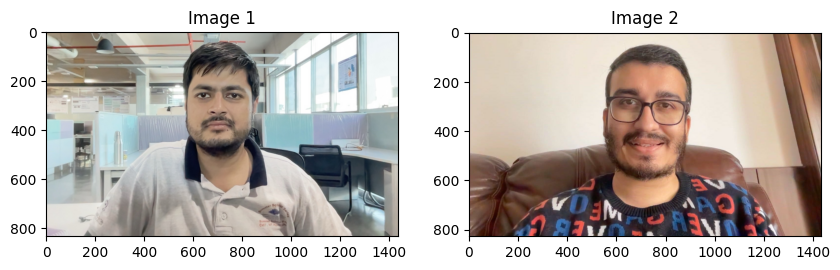

CPU times: user 825 ms, sys: 12.6 ms, total: 837 ms
Wall time: 301 ms


In [17]:
%%time
image1 = cv2.imread('./inputs/wc_diverse_bkg_1.jpeg', cv2.IMREAD_COLOR)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('./inputs/wc_diverse_bkg_2.jpeg', cv2.IMREAD_COLOR)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
output_directory = "./outputs"

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Image 2')

plt.show()

# 1.Gain Consistency

In [18]:
%%time
target_image = np.copy(image1)
source_image = np.copy(image2)
if target_image.shape[:2] != source_image.shape[:2]:
    source_image = cv2.resize(source_image, (target_image.shape[1], target_image.shape[0]))

#storing before applying tansformation
image1_original,image2_original = np.copy(target_image),np.copy(source_image)

gainConsistency = GainConsistency()
transformed_image = gainConsistency.caliberateColor(target_image,source_image)

print("Color Callibiration Done")

Finding transform for gain consistency...
Color Callibiration Done
CPU times: user 61.9 ms, sys: 14.1 ms, total: 76.1 ms
Wall time: 55 ms


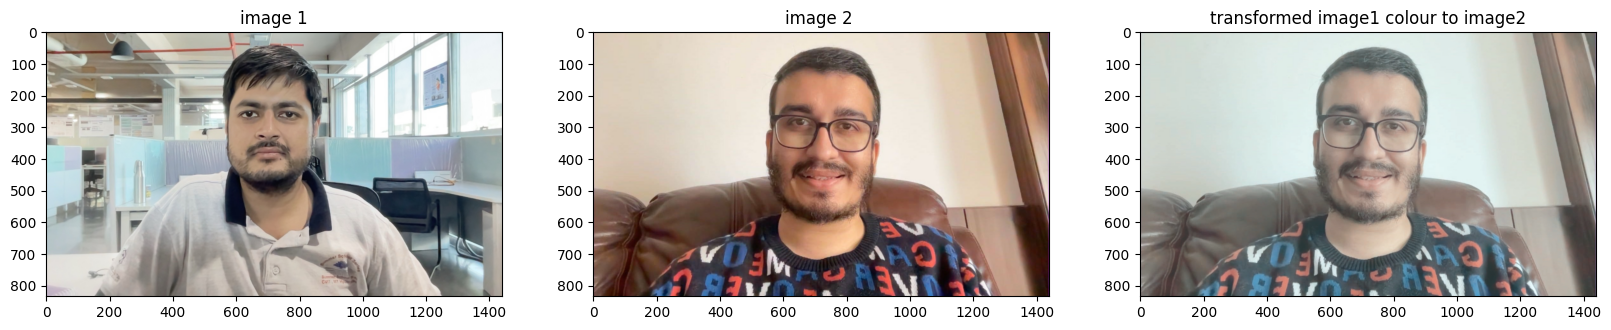

In [19]:
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(target_image)
plt.title("image 1")
plt.subplot(1, 3, 2)
plt.imshow(source_image)
plt.title("image 2 ")
plt.subplot(1, 3, 3)
plt.imshow(transformed_image)
plt.title("transformed image1 colour to image2")
plt.show()

In [20]:
image1 = np.copy(target_image)
image2 = np.copy(transformed_image)

# 2.Flipping Lips

In [21]:
%%time
lipflip = FlipLips()
lip_detection1,lip_detection2 = lipflip.detect_face_mouth(image1),lipflip.detect_face_mouth(image2)
mouth1,mouth2 = lipflip.detect_face_mouth(image1,show = False),lipflip.detect_face_mouth(image2,show=False)
image1_result, image2_result = lipflip.swap_and_resize_mouths(image1, image2,mouth1,mouth2)
image1_result_o, image2_result_o = lipflip.swap_and_resize_mouths(image1_original, image2_original,mouth1,mouth2)
mask1,mask2 = lipflip.generate_mask(image1,mouth1),lipflip.generate_mask(image2,mouth2)

CPU times: user 864 ms, sys: 21.4 ms, total: 885 ms
Wall time: 230 ms


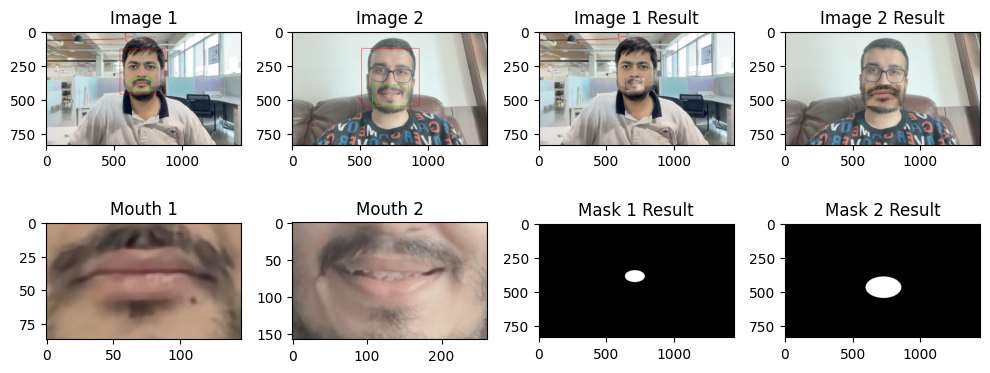

In [22]:
plt.figure(figsize=(10, 4))

# Plotting lip detection images
plt.subplot(2, 4, 1);plt.imshow(lip_detection1);plt.title('Image 1')
plt.subplot(2, 4, 2);plt.imshow(lip_detection2);plt.title('Image 2')

# Plotting image results
plt.subplot(2, 4, 3);plt.imshow(image1_result);plt.title('Image 1 Result')
plt.subplot(2, 4, 4);plt.imshow(image2_result);plt.title('Image 2 Result')

# Plotting mouth regions
plt.subplot(2, 4, 5);plt.imshow(image1[mouth1[0]:mouth1[1], mouth1[2]:mouth1[3]]);plt.title("Mouth 1")
plt.subplot(2, 4, 6);plt.imshow(image2[mouth2[0]:mouth2[1], mouth2[2]:mouth2[3]]);plt.title("Mouth 2")

# Plotting mask results => used for blending in next part
plt.subplot(2, 4, 7);plt.imshow(mask1, cmap="gray");plt.title('Mask 1 Result')
plt.subplot(2, 4, 8);plt.imshow(mask2, cmap="gray");plt.title('Mask 2 Result')

plt.tight_layout()
plt.show()

# 3. Laplacian Blending

In [23]:
class Blending():
    def __init__(self):
        pass
    
    def upsample(self,image, dst_shape):
        return cv2.pyrUp(image, dstsize=(dst_shape[1], dst_shape[0]))

    def downsample(self,image):    
        cols = image.shape[1] // 2
        rows = image.shape[0] // 2                                             
        return cv2.pyrDown(image, dstsize=(cols, rows))    

    def pyramids(self,image):
        gaussian_pyramid = [image, ]
        laplacian_pyramid = []

        while image.shape[0] > 2 and image.shape[1] > 2:
            image = self.downsample(image)
            gaussian_pyramid.append(image)

        for i in range(len(gaussian_pyramid) - 1):
            laplacian_pyramid.append(gaussian_pyramid[i] - self.upsample(gaussian_pyramid[i + 1], gaussian_pyramid[i].shape))

        return gaussian_pyramid[:-1], laplacian_pyramid

    def pyramidBlending(self,A, B, mask):
        _, source_LA = self.pyramids(A)
        _ ,dest_LB = self.pyramids(B)
        Gmask, _ = self.pyramids(mask)
        blend = []
        for i in range(len(source_LA)):
            LS = (Gmask[i]/255)*source_LA[i] + (1-(Gmask[i]/255))*dest_LB[i]
            blend.append(LS)
        return blend

    def collapse_pyramid(self,pyramid):
        small_to_big_pyramid = pyramid[::-1]
        collapsed_output = small_to_big_pyramid[0]
        for i in range(1, len(small_to_big_pyramid)):
            collapsed_output = self.upsample(collapsed_output, small_to_big_pyramid[i].shape) + small_to_big_pyramid[i] # upsampling simultaneously
        return collapsed_output

    def colorBlending(self,img1, img2, mask):
        img1R,img1G,img1B = cv2.split(img1)
        img2R,img2G,img2B = cv2.split(img2)
        R = self.collapse_pyramid(self.pyramidBlending(img1R, img2R, mask))
        G = self.collapse_pyramid(self.pyramidBlending(img1G, img2G, mask))
        B = self.collapse_pyramid(self.pyramidBlending(img1B, img2B, mask))
        output = (cv2.merge((B, G, R)))
        output = 0 + (255/(np.max(output) - np.min(output))) * (output - np.min(output))
        return output

In [24]:
%%time
# smoothening image1
destination = image1.astype(np.float32)
source = image1_result.astype(np.float32)
mask_from_source = mask1.astype(np.float32)

blend = Blending()
output = blend.colorBlending(source, destination, mask_from_source)
output1 = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

#smoothening image2
destination = image2.astype(np.float32)
source = image2_result.astype(np.float32)
mask_from_source = mask2.astype(np.float32)

blend = Blending()
output = blend.colorBlending(source, destination, mask_from_source)
output2 = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

CPU times: user 62.7 ms, sys: 52.8 ms, total: 116 ms
Wall time: 101 ms


# 4. Final Results

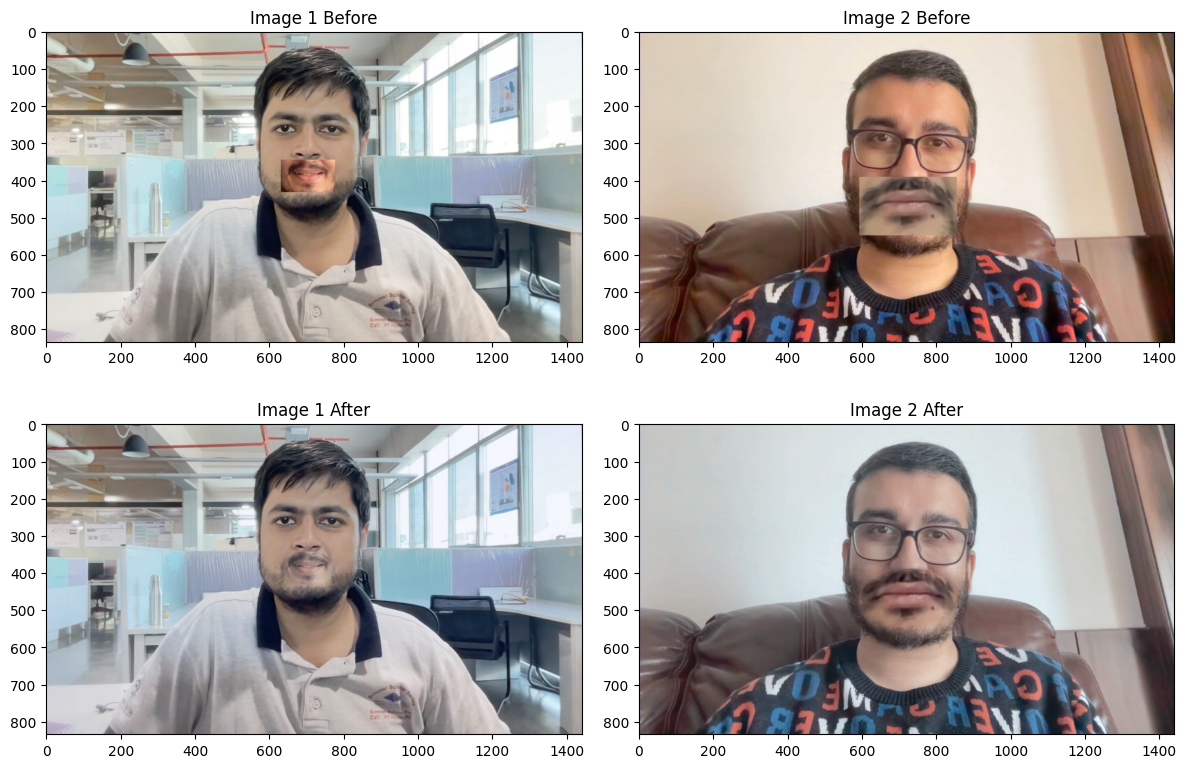

In [25]:
plt.figure(figsize=(12, 8))

# Plotting image results before
plt.subplot(2, 2, 1);plt.imshow(image1_result_o);plt.title('Image 1 Before')
plt.subplot(2, 2, 2);plt.imshow(image2_result_o);plt.title('Image 2 Before')

# Plotting image results after
plt.subplot(2, 2, 3);plt.imshow(output1.astype(int));plt.title("Image 1 After")
plt.subplot(2, 2, 4);plt.imshow(output2.astype(int));plt.title("Image 2 After")

plt.tight_layout()
plt.savefig(os.path.join(output_directory, "final_lip_flip.jpeg"))